In [21]:
from __future__ import division

# import requests
import json
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

## Common Functions

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cases_till_date(modelName, df, date_col, population = None):
    count = 0
    grouped_df = df.groupby(date_col)['patientId'].nunique().reset_index()
    grouped_df = grouped_df.sort_values(by=date_col, ascending=True)
    grouped_df = populate_missing_days(grouped_df,date_col)
    grouped_df['date'] = grouped_df[date_col]
    
    if(modelName == 'fixExp' or modelName == 'fitExp'):
        grouped_df['cases_count'] = grouped_df['patientId'].rolling(min_periods=1, window=recovery_days).sum()
        grouped_df['cases_count'] = grouped_df['cases_count'] * under_reporting_factor
        grouped_df['cases_count'] = grouped_df['cases_count'].round()
        grouped_df['population'] = population
        grouped_df = grouped_df.loc[:,['date','cases_count','population']]
        return populate_missing_days(grouped_df,'date')
        
    elif(modelName == 'sir'):
        
        #### SEMANTICS
    #### For each date the semantics of the columns
    #### new_infected -  new cases reported on a particular date
    #### active_infected - cases reported in last 14 days (earlier ones are cured)
    #### beg_susceptible - susceptible people at the begining of the day
    #### end_susceptible - susceptible people at the end of the day
    #### recovered - cases that got recovered on the particular date or the ones who were new infected on today - 14 days
    ####


        
        grouped_df['date'] = grouped_df[date_col]
        grouped_df['new_infected_count'] = grouped_df['patientId'] * under_reporting_factor
        grouped_df['active_infected_count'] = grouped_df['patientId'].rolling(min_periods=1, window=recovery_days).sum()
        grouped_df['recovered_count'] = 0
        grouped_df['end_susceptible_count'] = population - grouped_df['new_infected_count'] 
        grouped_df['beg_susceptible_count'] = population
        grouped_df['active_propagators'] = grouped_df['patientId'].rolling(min_periods=1, window=incubation_period).sum()
        
        for index, row in grouped_df.iterrows():
            if(index>0):
                history_row = fetch_historical_row(index,recovery_days,grouped_df)
                grouped_df.at[index,'beg_susceptible_count'] = grouped_df.iloc[index-1,grouped_df.columns.get_loc('end_susceptible_count')]
            
                grouped_df.at[index,'recovered_count'] = history_row['new_infected_count']
            
                grouped_df.at[index,'end_susceptible_count'] = max(0,grouped_df.iloc[index,grouped_df.columns.get_loc('beg_susceptible_count')] - grouped_df.iloc[index,grouped_df.columns.get_loc('new_infected_count')] )
        
        grouped_df = grouped_df.loc[:,['date','new_infected_count','active_infected_count','recovered_count','beg_susceptible_count','end_susceptible_count','population']]
        
        return populate_missing_days(grouped_df,'date')
    
    else:
        print("modelName should be \'fitExp\', \'fixExp\', or \'sir\', but found: " + modelName)
        
        return None


def cases_last_5days(df,history_days,modelName,col_name):
    if(modelName == 'fixExp' or modelName == 'fitExp' or modelName == 'sir'):
        counts = []  
        for index, row in df.iterrows():
            flat = {}
            flat['date'] = row['date']
            for i in range(history_days):
                flat['active_infected_count_-'+str(i)] = fetch_value(df[col_name], index-i)
            counts.append(flat)
    else:
        print("modelName should be \'fitExp\', \'fixExp\', or \'sir\', but found: " + modelName)
 
    return pd.DataFrame(counts)

In [3]:
def populate_missing_days(df,date_col):    
    r = pd.date_range(start=df[date_col].min(), end=day0) 
    df = df.set_index(date_col).reindex(r).fillna(0.0).rename_axis(date_col).reset_index()
    return df

def fetch_historical_row(current_index, relative_position, df):
    #row= pd.DataFrame([[0]*df.shape[1]],columns=df.columns)
    row = df.iloc[0].copy()
    if((current_index-relative_position) >=0 ):
        row = df.iloc[current_index-relative_position,:]
    
    else:
        for column in df:
            row[column]=0
    return row

def fetch_value(df,index):
    if(index>=0):
        return df[index]
    else :
        return 0
    
def merge_dict(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

def fit_a(row,history_days,col_prefix):
    a = 0
    cnt = 0
    for i in range(history_days-1):
        if(row[col_prefix+"_-"+str(i+1)]>0):
            a = a + row[col_prefix+"_-"+str(i)]/row[col_prefix+"_-"+str(i+1)]
            cnt += 1

    if(a>1):
        return math.log(a/(cnt*1.0))
    else:
        return 0

In [4]:
def preprocess_dataset_regionwise(df, history_days, modelName, region_name, region_col):
    
    all_regions_df = pd.DataFrame()
    region_names = df[region_col].unique()
    #print(df.shape)
    for region in region_names:
        flat = {}
        flat[region_col] = region
        region_filtered_df = df[df[region_col]==region]
  
        ## TODO - check semnatics with spreadhseet and change code
        if(region_filtered_df.shape[0]>0):
            if(modelName == 'fixExp' or modelName == 'fitExp'):
                cases_df = cases_till_date(modelName, region_filtered_df,'reported_date',np.mean(region_filtered_df.population))  
                cases_region_df = cases_last_5days(cases_df,history_days, modelName,'cases_count')
                cases_region_df['population'] = round(np.mean(region_filtered_df.population))
                cases_region_df[region_col] = region
                #print(cases_region_df)
            
                current_active_count = cases_region_df.iloc[-1,cases_region_df.columns.get_loc('active_infected_count_-0')]
           
                if(current_active_count>early_growth_cut_off):
                    all_regions_df = all_regions_df.append(cases_region_df)
                
            elif(modelName == 'sir'):
                cases_df = cases_till_date(modelName, region_filtered_df,'reported_date',np.mean(region_filtered_df.population))  
                cases_last_5days_df = cases_last_5days(cases_df, history_days, modelName,'active_infected_count')
             
                cases_region_df = pd.merge(cases_last_5days_df, cases_df, left_on='date', right_on='date')
                cases_region_df['population'] = round(np.mean(region_filtered_df.population))
                cases_region_df[region_col] = region
                current_active_count = cases_region_df.iloc[-1,cases_region_df.columns.get_loc('active_infected_count_-0')]
                #print(cases_region_df)
                if(current_active_count > early_growth_cut_off):
                    all_regions_df = all_regions_df.append(cases_region_df.drop_duplicates())
    return all_regions_df


## Projection Logic

In [5]:
def project_1day(row_today,a,history_days):
    row_next_day = row_today.copy()
    
    row_next_day['date'] = row_today['date'] + timedelta(days=1)
    #print("new adjusted count= "+str(row_today['adjusted_count_-0'])+" * "+str(math.exp(1*a)))
    row_next_day['active_infected_count_-0'] = round(row_today['active_infected_count_-0'] * math.exp(1*a))
    
    for i in range(history_days-1):
        row_next_day['active_infected_count_-'+str(i+1)] = row_today['active_infected_count_-'+str(i)]   

    return row_next_day


def predict_medical_demand(projection, n):
    flat ={}
    flat[str(n)+'days_projection_date'] = projection['date'] 
    flat[str(n)+'days_infected'] = projection['active_infected_count_-0']      
    flat[str(n)+'days_hospitalized'] = round(flat[str(n)+'days_infected'] * F_hospitalized)
    flat[str(n)+'days_need_icu'] = round(flat[str(n)+'days_infected'] * F_need_ICU)
    flat[str(n)+'days_need_ventilator'] = round(flat[str(n)+'days_infected'] * F_need_Ventilator)
    flat[str(n)+'days_fatality'] = round(flat[str(n)+'days_infected'] * F_fatality)          
    return flat

def predict_medical_demand_sir(projection,n):
    flat = {}
    
    flat[str(n)+'days_projection_date'] = projection['date'] 
    flat[str(n)+'days_infected'] = projection['active_infected_count']      
    flat[str(n)+'days_hospitalized'] = round(flat[str(n)+'days_infected'] * F_hospitalized)
    flat[str(n)+'days_need_icu'] = round(flat[str(n)+'days_infected'] * F_need_ICU)
    flat[str(n)+'days_need_ventilator'] = round(flat[str(n)+'days_infected'] * F_need_Ventilator)
    flat[str(n)+'days_fatality'] = round(flat[str(n)+'days_infected'] * F_fatality)        
    return flat

def predict_medical_demand_fixExp(projection,a,day_offset,n):
    flat ={}
    flat[str(n)+'days_projection_date'] = projection['date'] + timedelta(days=(n+day_offset))
    flat[str(n)+'days_infected'] = round(projection['active_infected_count_-0']  *  math.exp((n+day_offset)*a))
    flat[str(n)+'days_hospitalized'] = round(flat[str(n)+'days_infected'] * F_hospitalized)
    flat[str(n)+'days_need_icu'] = round(flat[str(n)+'days_infected'] * F_need_ICU)
    flat[str(n)+'days_need_ventilator'] = round(flat[str(n)+'days_infected'] * F_need_Ventilator)
    flat[str(n)+'days_fatality'] = round(flat[str(n)+'days_infected'] * F_fatality)          
    return flat


In [6]:
def project_ndays_fitExp(row_today,day_offset,n):
    projections = []
    save_today = row_today
    z = {}
       
    for i in range(n+day_offset):
        a = fit_a(row_today,history_days,'active_infected_count')
        
        row_next_day = project_1day(row_today,a,history_days)
        row_today = row_next_day
        
    return predict_medical_demand(row_today,n),a



pd.set_option('display.float_format', lambda x: '%.3f' % x)
def project_ndays_sir(count_ts_df,day_offset,n,recovery_days, incubation_period):

    ## TODO - check semnatics with spreadhseet and change code 
    for i in range(0,n+day_offset,jump):
        
        row_today = count_ts_df.iloc[-1,:]
        row_prior_recovery_days = fetch_historical_row(count_ts_df.shape[0], 14, count_ts_df)
        row_prior_incubation_period =   fetch_historical_row(count_ts_df.shape[0], 4, count_ts_df)
        #row_next_day = fetch_historical_row(i, 0, count_ts_df)        
        row_next_day = row_today.copy()
        #print("old ")
        row_next_day['date'] = row_today['date'] + timedelta(days=jump) 
        row_next_day['beg_susceptible_count'] = row_today['end_susceptible_count']        
        row_next_day['new_infected_count'] = round(row_today['new_infected_count'] * r0 * (row_next_day['beg_susceptible_count']/(1.0*row_today['population'])))
        row_next_day['recovered_count'] =  row_prior_recovery_days['new_infected_count']
        ## check this to incorporate incubation period, and not recovery period
        #row_next_day['active_infected_count'] = sum(fetch_historical_row(count_ts_df.shape[0], i, count_ts_df)['new_infected_count'] for i in range(1, incubation_period))
        row_next_day['active_infected_count'] = row_today['active_infected_count'] - row_next_day['recovered_count'] + row_next_day['new_infected_count']
        row_next_day['end_susceptible_count'] = max(0, row_next_day['beg_susceptible_count'] - row_next_day['recovered_count'] - row_next_day['new_infected_count'])
        #print(row_next_day)
        count_ts_df = count_ts_df.append(row_next_day)
       
    
    latest_row = count_ts_df.iloc[-1,:]
    return predict_medical_demand_sir(latest_row,n)

def rename_dict(proj_dict,n):
    proj_dict['projection_date']  = proj_dict.pop(str(n)+'days_projection_date') 
    proj_dict['infected_count'] = proj_dict.pop(str(n)+'days_infected') 
    proj_dict['hospitalized_count'] = proj_dict.pop(str(n)+'days_hospitalized')  
    proj_dict['need_icu_count'] = proj_dict.pop(str(n)+'days_need_icu') 
    proj_dict['need_ventilator_count'] = proj_dict.pop(str(n)+'days_need_ventilator')  
    proj_dict['fatality_count'] = proj_dict.pop(str(n)+'days_fatality')           
    return proj_dict
        

In [7]:
def projections(region_date_count_df, nList, modelName, region=None, region_col=""):
    final_projections = []

    if(modelName == 'fixExp' or modelName == 'fitExp'):
        
        grouped_df = region_date_count_df[region_date_count_df.groupby([region_col])['date'].transform(max) == region_date_count_df['date']]   
        for index, row in grouped_df.iterrows():        
            flat = {}
            
            #print(row[region_col],row['date'],row['active_infected_count_-0'])
            flat[region_col] = row[region_col]
            flat['current_date'] = row['date']
            #print(row['population'])
            flat['population'] = row['population']
            flat['current_infected_count'] = row['active_infected_count_-0']
            flat['current day-4 Infected'] = row['active_infected_count_-4']
            flat['current day-3 Infected'] = row['active_infected_count_-3']
            flat['current day-2 Infected'] = row['active_infected_count_-2']
            flat['current day-1 Infected'] = row['active_infected_count_-1']


            day_offset = (datetime.today() - row['date']).days
            if(modelName == 'fitExp'):
                projs_dict = {}
                for time in nList:
                    projection,a = project_ndays_fitExp(row, day_offset, time)
                    projs_dict = merge_dict(projs_dict, projection)
                    
                flat['a_fitted'] = a
                
            elif(modelName == 'fixExp'):
                a = a_fixed
                projs_dict = {}
                for time in nList:
                    projection = predict_medical_demand_fixExp(row,a, day_offset, time)
                    projs_dict = merge_dict(projs_dict, projection)

            temp = merge_dict(flat,projs_dict)
            final_projections.append(temp)
            #print(row)

    elif(modelName == 'sir'):
        all_regions_df = pd.DataFrame() 
        regions = region_date_count_df[region_col].unique()
        for region in regions:
            region_filtered_df = region_date_count_df[region_date_count_df[region_col]==region]

            flat = {}
            last_row = region_filtered_df.iloc[-1,:]
            flat[region_col] = region
            flat['population'] = region_filtered_df['population'].mean()
            flat['current_date'] = last_row['date']
            flat['current_infected_count'] = last_row['active_infected_count_-0']
            flat['current day-4 Infected'] = last_row['active_infected_count_-4']
            flat['current day-3 Infected'] = last_row['active_infected_count_-3']
            flat['current day-2 Infected'] = last_row['active_infected_count_-2']
            flat['current day-1 Infected'] = last_row['active_infected_count_-1']

            last_date = region_filtered_df.iloc[-1,region_filtered_df.columns.get_loc('date')]
            day_offset = (datetime.today() - last_date).days

            projs_dict = {}
            for time in nList:
                    projection = project_ndays_sir(region_filtered_df, day_offset, time, recovery_days, incubation_period)
                    projs_dict = merge_dict(projs_dict, projection)
                    #print(projs_dict)

            temp = merge_dict(flat,projs_dict)
            final_projections.append(temp)
    else:
        print("modelName should be \'fitExp\', \'fixExp\', or \'sir\', but found: " + modelName) 
        
    
    #print(final_projections)
    return pd.DataFrame(final_projections)


In [8]:
def projections_format2(region_date_count_df, n_days, modelName, region=None, region_col=""):
    final_projections = []
    n_days = max(n_days)
    if(modelName == 'fixExp' or modelName == 'fitExp'):
        #print(region_date_count_df)
        grouped_df = region_date_count_df[region_date_count_df.groupby([region_col])['date'].transform(max) == region_date_count_df['date']]   
        for index, row in grouped_df.iterrows():        
            
            #print(row[region_col],row['date'],row['active_infected_count_-0'])
            region_name = row[region_col]
            #print(region_name)
            day_offset = (datetime.today() - row['date']).days
            if(modelName == 'fitExp'):
                projs_dict = {}
                for time in range(n_days+day_offset):
                    projection,a = project_ndays_fitExp(row, 0, time+1)
                    projection[region_col] = region_name
                    projection['a_fitted'] = a
                    renamed_dict = rename_dict(projection, time+1)
                    final_projections.append(renamed_dict)

                
            elif(modelName == 'fixExp'):
                a = a_fixed
                projs_dict = {}
                for time in range(n_days+day_offset):
                    projection = predict_medical_demand_fixExp(row,a, 0, time+1)
                    projection[region_col] = region_name
                    renamed_dict = rename_dict(projection, time+1)
                    final_projections.append(renamed_dict)

            #print(row)

    elif(modelName == 'sir'):
        all_regions_df = pd.DataFrame() 
        regions = region_date_count_df[region_col].unique()
        for region in regions:
            region_filtered_df = region_date_count_df[region_date_count_df[region_col]==region]

            flat = {}
            last_row = region_filtered_df.iloc[-1,:]

            last_date = region_filtered_df.iloc[-1,region_filtered_df.columns.get_loc('date')]
            day_offset = (datetime.today() - last_date).days

            projs_dict = {}
            for time in range(n_days+day_offset):
                    projection = {}
                    projection = project_ndays_sir(region_filtered_df, 0, time+1, recovery_days, incubation_period)
                    projection[region_col] = region
                    renamed_dict = rename_dict(projection, time+1)
                    final_projections.append(renamed_dict)

    else:
        print("modelName should be \'fitExp\', \'fixExp\', or \'sir\', but found: " + modelName) 
        
    
    #print(final_projections)
    return pd.DataFrame(final_projections)




# TopLevel Function

In [9]:
def predict(modelName, nList, patient_data_file, region, region_col,output_format, output_file_path, region_population_data_file = None):
    patient_data_df = pd.read_csv(patient_data_file,na_values='')
#     if('statewise_population' in region_population_data_file):
#         delimiter = '\t'
#     elif('district' in region_population_data_file):
#         delimiter = ','
#     else:
#         delimiter = ' '
    region_population = pd.read_csv(region_population_data_file,sep=',')
#     region_population = region_population.rename(columns={'State': 'state'})
        #print(region_population)
    patient_data_df[region_col] = patient_data_df[region_col].str.strip()
    region_population[region_col] = region_population[region_col].str.strip()
    region_population_df = region_population.loc[:,[region_col,'population']]
    patient_data_df = patient_data_df.merge(region_population_df,on=region_col)
        
    patient_data_df['reported_date'] = pd.to_datetime(patient_data_df['reportedOn'], infer_datetime_format=True)
    
    end = datetime.today()
    patient_data_df['reported_date'] = patient_data_df['reported_date'].fillna(end)
    
    region_wise_counts = preprocess_dataset_regionwise(patient_data_df, history_days, modelName, region, region_col)

    region_file = region + "wise_counts_model_"+ modelName +"_under_reporting_factor_" + str(under_reporting_factor) + ".csv"
    region_wise_counts.to_csv(region_file)

    outfile_prefix = output_file_path[0:output_file_path.rfind('.')]
    date = datetime.today().strftime("%b%d%Y")
    
    if(region_wise_counts.shape[0]>0):
        if(output_format==1):
            projections_df = projections(region_wise_counts, nList, modelName,  region, region_col)
            outfile_prefix = outfile_prefix +"_"+ str(date) +" "+ region + "wise_model_"+ modelName +"_under_reporting_factor_" + str(under_reporting_factor) 

        elif(output_format==2):
            projections_df = projections_format2(region_wise_counts, nList, modelName,  region, region_col)
            outfile_prefix = outfile_prefix +"_"+ str(date) +" "+ region + "_and_datewise_model_"+ modelName +"_under_reporting_factor_" + str(under_reporting_factor) 

    
        
        if(modelName == 'sir'):
            outfile_prefix = outfile_prefix + '_r0_' + str(r0)
        elif(modelName == 'fixExp'):
            outfile_prefix = outfile_prefix + '_a_' + str(a_fixed)
        
#         projections_df.to_csv(outfile_prefix+".csv")
        #print(projections_df)

        return projections_df.drop_duplicates()
    else:
        print("No "+region+" with active count greater than threshold")

In [11]:
####  output_format = 1 for medical demand and output_format = 2 for daywise count


##### region = 'district' and region_col ='district' and population_data_file = 'state_population.csv'  for district level
#### region = 'state' and region_col ='state' and population_data_file = 'district_population.csv' for state level
#### region = 'country' and region_col ='country' and population_data_file = 'country_population.csv' for country level


input_file = 'patient_id_data_2403_district_imputed.csv'
model = 'sir'
output_format = 2
output_file = '⁨⁩counts.csv'
population_data_file = 'state_population.csv'
region = 'state'
region_col = 'state'
jump = 1


under_reporting_factor = 1
incubation_period = 5
a_fixed = 0.3
recovery_days = 14
early_growth_cut_off = 5 
F_hospitalized =  .26
F_need_ICU = .082
F_need_Ventilator = .05
F_fatality = .026
r0= 1.2 #Not Required unless SIR
history_days = 5 
day0 = datetime.strptime('2020-03-24',"%Y-%m-%d")




In [ ]:
projections_df = predict(model, [14], input_file, region, region_col, output_format , output_file ,population_data_file)

## Merging Results

### State wise

In [43]:
import copy
permutations = dict()
permutations['sir'] = {'r0': [1.3, 1.1, 0.8]}
permutations['fixExp'] = {'a': [0.3, 0.1 ,-.05]}


input_file = 'patient_id_data_2403_district_imputed.csv'
model = 'fixExp'
output_format = 2
output_file = '⁨⁩counts.csv'
region = 'state'
population_data_file = 'state_population.csv'.format(region)
region_col = region
nList = [270]
observed_count_file = 'statewise_observed_counts.csv'
jump = 4
compute_mape = False

under_reporting_factor = 1
a_fixed = 0.3
recovery_days = 14
early_growth_cut_off = 5 
F_hospitalized =  .26
F_need_ICU = .082
F_need_Ventilator = .05
F_fatality = .026
r0= 1.2 #Not Required unless SIR
history_days = 5 
day0 = datetime.strptime('2020-03-24',"%Y-%m-%d")

fixedCols = []
if(output_format == 1):
    columnsToFetch = []
    fixedCols.append("current_date")
    fixedCols.append("current day-1 Infected")
    fixedCols.append("current day-2 Infected")
    fixedCols.append("current day-3 Infected")
    fixedCols.append("current day-4 Infected")
    fixedCols.append("current_infected_count")
    for n in nList:
        fixedCols.append("{}days_projection_date".format(n))
        #columnsToFetch.append(region_col)
        columnsToFetch.append("{}days_infected".format(n))
        columnsToFetch.append("{}days_hospitalized".format(n))
        columnsToFetch.append("{}days_need_icu".format(n))
        columnsToFetch.append("{}days_need_ventilator".format(n))
        columnsToFetch.append("{}days_fatality".format(n))
elif(output_format == 2):
    columnsToFetch = ['infected_count']
    fixedCols.append(region_col)
    #columnsToFetch.append(region_col)
    fixedCols.append("projection_date")
else:
    print(output_format)




projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)

projections_df = projections_df[fixedCols]
mergedDf = projections_df.copy()

for model in permutations:
    for key in permutations[model]:
        for value in permutations[model][key]:
            if(key == 'r0'):
                r0 = value
            elif(key == 'a'):
                a_fixed = value
            else:
                print("Error:", key, value)
            print("Computing for {} with key {} and value {}".format(model, key, value))
            projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)
            temp = copy.deepcopy(fixedCols)
            temp.extend(columnsToFetch)
            projections_df = projections_df[temp]
            for col in columnsToFetch:
                projections_df = projections_df.rename(columns = {col: "{}_{}_{}_{}".format(col, model, key, value)})
            mergedDf = mergedDf.merge(projections_df, on= fixedCols)
            
model = 'fitExp'
projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)
temp = copy.deepcopy(fixedCols)
temp.extend(columnsToFetch)
temp.append("a_fitted")
projections_df = projections_df[temp]
for col in columnsToFetch:
    projections_df = projections_df.rename(columns = {col: "{}_fitExp".format(col)})
mergedDf = mergedDf.merge(projections_df, on= fixedCols)

statewise_merged_df = mergedDf
if(compute_mape):
    statewise_compute_mape()


### Compute MAPE
def statewise_compute_mape():
    statewise_observed_df = pd.read_csv(observed_count_file)
    statewise_observed_df['reported_date'] = pd.to_datetime(statewise_observed_df['reported_date'], infer_datetime_format=True)
    statewise_predictions_df = statewise_observed_df.merge(statewise_merged_df,left_on=['state','reported_date'],right_on=['state','projection_date'])


    states= statewise_predictions_df.state.unique()
    error_list = []
    for state in states:
        flat = {}
        flat['state'] = state
        temp = statewise_predictions_df[statewise_predictions_df.state==state]
        projected_columns = statewise_predictions_df.filter(regex=("infected_count.*")).columns
        for col in projected_columns:
            flat['mape_'+col] = mean_absolute_percentage_error(temp['active_cases_count'],temp[col])
        error_list.append(flat)
    (pd.DataFrame(error_list)).to_csv(region+'wise_all_models_mape_scores.csv')

            

Computing for sir with key r0 and value 1.3


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

Computing for sir with key r0 and value 1.1


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

Computing for sir with key r0 and value 0.8


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

Computing for fixExp with key a and value 0.3
Computing for fixExp with key a and value 0.1
Computing for fixExp with key a and value -0.05


### District wise

In [42]:
import copy
permutations = dict()
permutations['sir'] = {'r0': [1.3, 1.1, 0.8]}
permutations['fixExp'] = {'a': [0.3, 0.1,-.05]}


input_file = 'patient_id_data_2403_district_imputed.csv'
model = 'fixExp'
output_format = 2
output_file = '⁨⁩counts.csv'
region = 'district'
population_data_file = 'district_population.csv'.format(region)
region_col = region
nList = [270]
compute_mape = False
jump = 4

under_reporting_factor = 1
a_fixed = 0.3
recovery_days = 14
early_growth_cut_off = 5 
F_hospitalized =  .26
F_need_ICU = .082
F_need_Ventilator = .05
F_fatality = .026
r0= 1.2 #Not Required unless SIR
history_days = 5 
day0 = datetime.strptime('2020-03-24',"%Y-%m-%d")

fixedCols = []
if(output_format == 1):
    columnsToFetch = []
    fixedCols.append("current_date")
    fixedCols.append("current day-1 Infected")
    fixedCols.append("current day-2 Infected")
    fixedCols.append("current day-3 Infected")
    fixedCols.append("current day-4 Infected")
    fixedCols.append("current_infected_count")
    for n in nList:
        fixedCols.append("{}days_projection_date".format(n))
        #columnsToFetch.append(region_col)
        columnsToFetch.append("{}days_infected".format(n))
        columnsToFetch.append("{}days_hospitalized".format(n))
        columnsToFetch.append("{}days_need_icu".format(n))
        columnsToFetch.append("{}days_need_ventilator".format(n))
        columnsToFetch.append("{}days_fatality".format(n))
elif(output_format == 2):
    columnsToFetch = ['infected_count']
    fixedCols.append(region_col)
    #columnsToFetch.append(region_col)
    fixedCols.append("projection_date")
else:
    print(output_format)




projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)

projections_df = projections_df[fixedCols]
mergedDf = projections_df.copy()

for model in permutations:
    for key in permutations[model]:
        for value in permutations[model][key]:
            if(key == 'r0'):
                r0 = value
            elif(key == 'a'):
                a_fixed = value
            else:
                print("Error:", key, value)
            print("Computing for {} with key {} and value {}".format(model, key, value))
            projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)
            temp = copy.deepcopy(fixedCols)
            temp.extend(columnsToFetch)
            projections_df = projections_df[temp]
            for col in columnsToFetch:
                projections_df = projections_df.rename(columns = {col: "{}_{}_{}_{}".format(col, model, key, value)})
            mergedDf = mergedDf.merge(projections_df, on= fixedCols)
            
model = 'fitExp'
projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)
temp = copy.deepcopy(fixedCols)
temp.extend(columnsToFetch)
temp.append("a_fitted")
projections_df = projections_df[temp]
for col in columnsToFetch:
    projections_df = projections_df.rename(columns = {col: "{}_fitExp".format(col)})
mergedDf = mergedDf.merge(projections_df, on= fixedCols)

districtwise_merged_df = mergedDf



### Compute MAPE
def districtwise_compute_mape():

    districtwise_observed_df = pd.read_csv('districtwise_observed_counts.csv')
    districtwise_observed_df['reported_date'] = pd.to_datetime(districtwise_observed_df['reported_date'], infer_datetime_format=True)
    districtwise_predictions_df = districtwise_observed_df.merge(districtwise_merged_df,left_on=['district','reported_date'], right_on=['district','projection_date'])


    districts= districtwise_predictions_df.district.unique()
    error_list = []
    for district in districts:
        flat = {}
        flat['district'] = district
        temp = districtwise_predictions_df[districtwise_predictions_df.district==district]
        projected_columns = districtwise_predictions_df.filter(regex=("infected_count.*")).columns
        for col in projected_columns:
            flat['mape_'+col] = mean_absolute_percentage_error(temp['active_cases_count'],temp[col])
        error_list.append(flat)
    (pd.DataFrame(error_list)).to_csv(region+'wise_all_models_mape_scores.csv')

    
if(compute_mape):
    districtwise_compute_mape()


Computing for sir with key r0 and value 1.3


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

Computing for sir with key r0 and value 1.1


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

Computing for sir with key r0 and value 0.8


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the docu

Computing for fixExp with key a and value 0.3
Computing for fixExp with key a and value 0.1
Computing for fixExp with key a and value -0.05


### Country level

In [30]:
import copy
permutations = dict()
permutations['sir'] = {'r0': [1.3, 1.1, 0.8]}
permutations['fixExp'] = {'a': [0.3, 0.1,-.05]}


input_file = 'patient_id_data_2403_district_imputed.csv'
model = 'fixExp'
output_format = 2
output_file = '⁨⁩counts.csv'
region = 'country'
population_data_file = 'country_population.csv'.format(region)
region_col = region
nList = [270]

compute_mape = False
jump = 4
under_reporting_factor = 1
incubation_period = 4
a_fixed = 0.3
recovery_days = 14
early_growth_cut_off = 5 
F_hospitalized =  .26
F_need_ICU = .082
F_need_Ventilator = .05
F_fatality = .026
r0= 1.2 #Not Required unless SIR
history_days = 5 
day0 = datetime.strptime('2020-03-24',"%Y-%m-%d")

fixedCols = []
if(output_format == 1):
    columnsToFetch = []
    fixedCols.append("current_date")
    fixedCols.append("current day-1 Infected")
    fixedCols.append("current day-2 Infected")
    fixedCols.append("current day-3 Infected")
    fixedCols.append("current day-4 Infected")
    fixedCols.append("current_infected_count")
    for n in nList:
        fixedCols.append("{}days_projection_date".format(n))
        #columnsToFetch.append(region_col)
        columnsToFetch.append("{}days_infected".format(n))
        columnsToFetch.append("{}days_hospitalized".format(n))
        columnsToFetch.append("{}days_need_icu".format(n))
        columnsToFetch.append("{}days_need_ventilator".format(n))
        columnsToFetch.append("{}days_fatality".format(n))
elif(output_format == 2):
    columnsToFetch = ['infected_count']
    fixedCols.append(region_col)
    #columnsToFetch.append(region_col)
    fixedCols.append("projection_date")
else:
    print(output_format)



projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)

projections_df = projections_df[fixedCols]
mergedDf = projections_df.copy()

for model in permutations:
    for key in permutations[model]:
        for value in permutations[model][key]:
            if(key == 'r0'):
                r0 = value
            elif(key == 'a'):
                a_fixed = value
            else:
                print("Error:", key, value)
            print("Computing for {} with key {} and value {}".format(model, key, value))
            projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)
            temp = copy.deepcopy(fixedCols)
            temp.extend(columnsToFetch)
            projections_df = projections_df[temp]
            for col in columnsToFetch:
                projections_df = projections_df.rename(columns = {col: "{}_{}_{}_{}".format(col, model, key, value)})
            mergedDf = mergedDf.merge(projections_df, on= fixedCols)
            
model = 'fitExp'
projections_df = predict(model, nList, input_file, region, region_col, output_format , output_file ,population_data_file)
temp = copy.deepcopy(fixedCols)
temp.extend(columnsToFetch)
temp.append("a_fitted")
projections_df = projections_df[temp]
for col in columnsToFetch:
    projections_df = projections_df.rename(columns = {col: "{}_fitExp".format(col)})
mergedDf = mergedDf.merge(projections_df, on= fixedCols)

country_merged_df = mergedDf

def countrylevel_compute_mape():
    
    countrywise_observed_df = pd.read_csv('countrylevel_observed_counts.csv')
    countrywise_observed_df['reported_date'] = pd.to_datetime(countrywise_observed_df['reported_date'], infer_datetime_format=True)
    countrywise_predictions_df = countrywise_observed_df.merge(country_merged_df,left_on=['country','reported_date'], right_on=['country','projection_date'])


    countrys= countrywise_predictions_df.country.unique()
    error_list = []
    for country in countrys:
        flat = {}
        flat['country'] = country
        temp = countrywise_predictions_df[countrywise_predictions_df.country==country]
        projected_columns = countrywise_predictions_df.filter(regex=("infected_count.*")).columns
        for col in projected_columns:
            flat['mape_'+col] = mean_absolute_percentage_error(temp['active_cases_count'],temp[col])
        error_list.append(flat)
    (pd.DataFrame(error_list)).to_csv(region+'wise_all_models_mape_scores.csv')

if(compute_mape):
    countrylevel_compute_mape()


Computing for sir with key r0 and value 1.3


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Computing for sir with key r0 and value 1.1


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Computing for sir with key r0 and value 0.8


/Users/dm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Computing for fixExp with key a and value 0.3
Computing for fixExp with key a and value 0.1
Computing for fixExp with key a and value -0.05


## Plots

### All models varying params

### Country

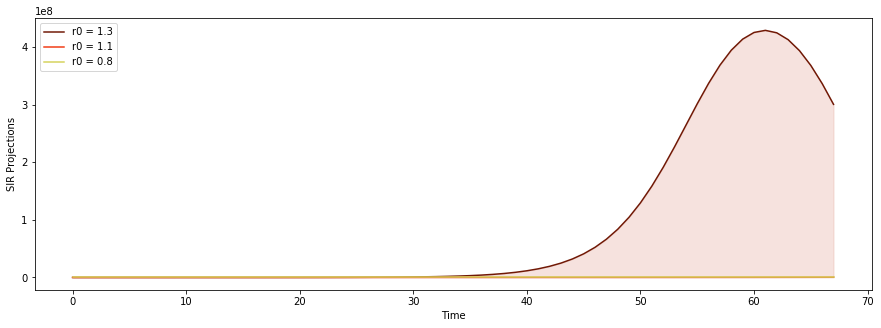

In [38]:
# plt.figure(figsize=(10,40))

dim = 68

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(dim), country_merged_df['infected_count_sir_r0_1.3'], color = '#701805', label = "r0 = 1.3")
ax.plot(range(dim), country_merged_df['infected_count_sir_r0_1.1'], color = '#F13B14', label = "r0 = 1.1")
ax.plot(range(dim), country_merged_df['infected_count_sir_r0_0.8'], color = '#D5D35C', label = "r0 = 0.8")
ax.fill_between(range(dim), country_merged_df['infected_count_sir_r0_1.3'], country_merged_df['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
#plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
plt.xlabel("Time")
plt.ylabel("SIR Projections")
#ax.set_yscale('log')
ax.legend()
# ax.plot(x, y, 'o', color='tab:brown')
plt.savefig("plots/sir_model_country_level.png")

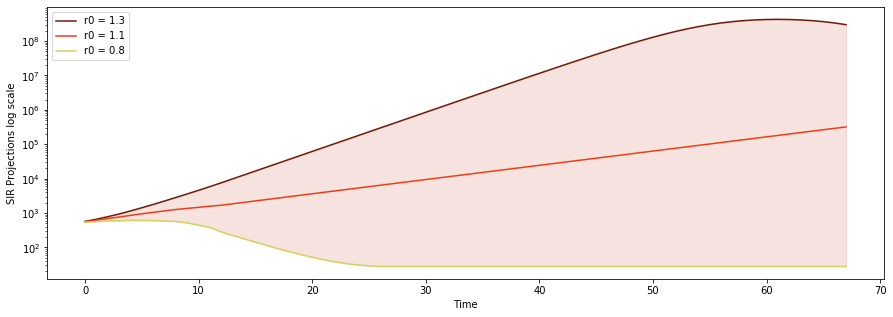

In [39]:
# plt.figure(figsize=(10,40))

dim = 68

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(dim), country_merged_df['infected_count_sir_r0_1.3'], color = '#701805', label = "r0 = 1.3")
ax.plot(range(dim), country_merged_df['infected_count_sir_r0_1.1'], color = '#F13B14', label = "r0 = 1.1")
ax.plot(range(dim), country_merged_df['infected_count_sir_r0_0.8'], color = '#D5D35C', label = "r0 = 0.8")
ax.fill_between(range(dim), country_merged_df['infected_count_sir_r0_1.3'], country_merged_df['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
#plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
plt.xlabel("Time")
plt.ylabel("SIR Projections log scale")
ax.set_yscale('log')
ax.legend()
#ax.plot(x, y, 'o', color='tab:brown')
plt.savefig("plots/sir_model_country_level_logscale.png")

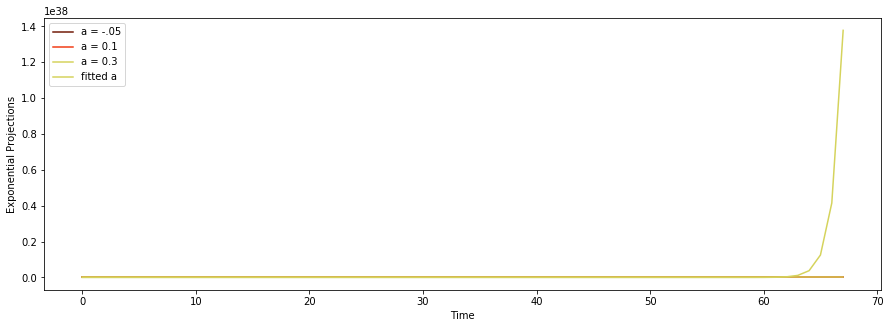

In [40]:
# plt.figure(figsize=(10,40))

dim = 68

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(dim), country_merged_df['infected_count_fixExp_a_-0.05'], color = '#701805', label = "a = -.05")
ax.plot(range(dim), country_merged_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "a = 0.1")
ax.plot(range(dim), country_merged_df['infected_count_fixExp_a_0.3'], color = '#D5D35C', label = "a = 0.3")
ax.plot(range(dim), country_merged_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted a")
ax.fill_between(range(dim), country_merged_df['infected_count_sir_r0_1.3'], country_merged_df['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
#plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
plt.xlabel("Time")
plt.ylabel("Exponential Projections")
#ax.set_yscale('log')
ax.legend()
# ax.plot(x, y, 'o', color='tab:brown')
plt.savefig("plots/exp_model_country_level.png")

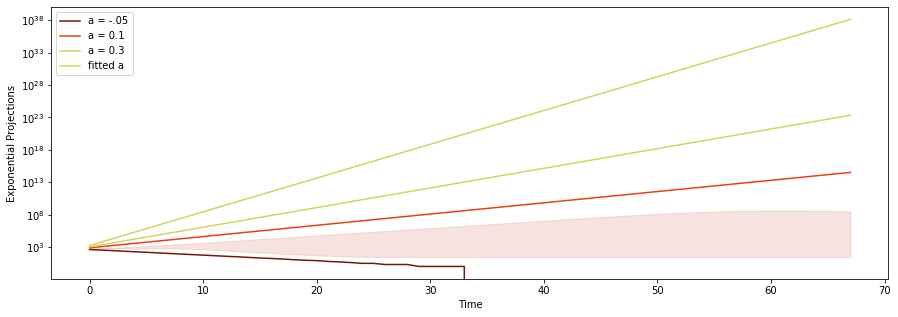

In [41]:
# plt.figure(figsize=(10,40))

dim = 68

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(dim), country_merged_df['infected_count_fixExp_a_-0.05'], color = '#701805', label = "a = -.05")
ax.plot(range(dim), country_merged_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "a = 0.1")
ax.plot(range(dim), country_merged_df['infected_count_fixExp_a_0.3'], color = '#D5D35C', label = "a = 0.3")
ax.plot(range(dim), country_merged_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted a")
ax.fill_between(range(dim), country_merged_df['infected_count_sir_r0_1.3'], country_merged_df['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
#plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
plt.xlabel("Time")
plt.ylabel("Exponential Projections")
ax.set_yscale('log')
ax.legend()
# ax.plot(x, y, 'o', color='tab:brown')
plt.savefig("plots/exp_model_country_level_logscale.png")

### State

In [44]:
state_list = ['Kerala','Maharashtra','Telangana','Karnataka','Rajasthan']
district_list = ['Kasaragod','Hyderabad','Bengaluru','Kannur','Sangli','Pune','Chennai','Ernakulam']

Kerala
Maharashtra
Telangana
Karnataka
Rajasthan


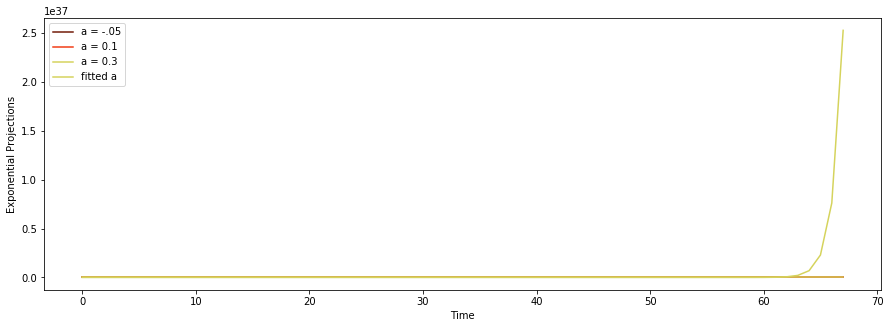

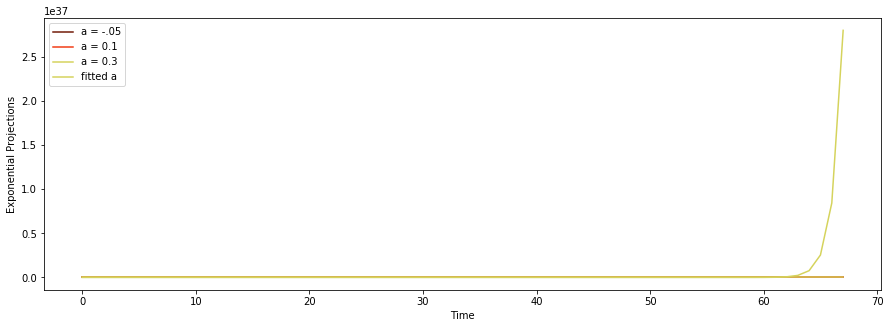

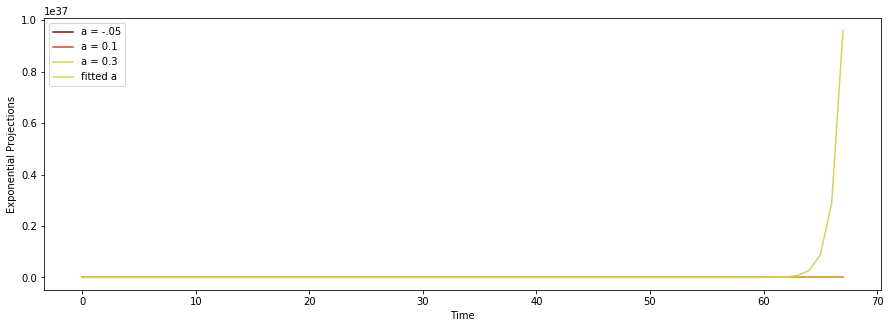

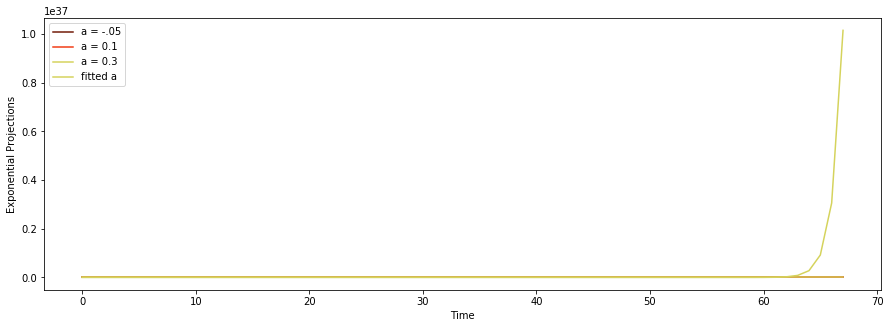

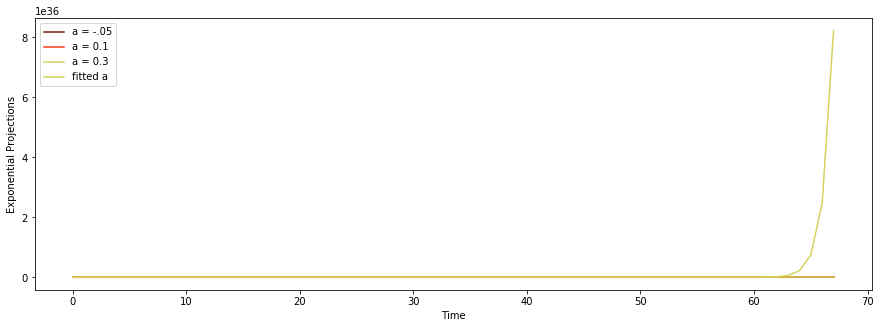

In [47]:
dim = 68
    
for state in state_list:
    state_df = statewise_merged_df[statewise_merged_df.state==state]
    print(state)
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), state_df['infected_count_fixExp_a_-0.05'], color = '#701805', label = "a = -.05")
    ax.plot(range(dim), state_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "a = 0.1")
    ax.plot(range(dim), state_df['infected_count_fixExp_a_0.3'], color = '#D5D35C', label = "a = 0.3")
    ax.plot(range(dim), state_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted a")
    #plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
    plt.xlabel("Time")
    plt.ylabel("Exponential Projections")
    #ax.set_yscale('log')
    ax.legend()
    # ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + state + "exp_model.png"
    plt.savefig(outfile)

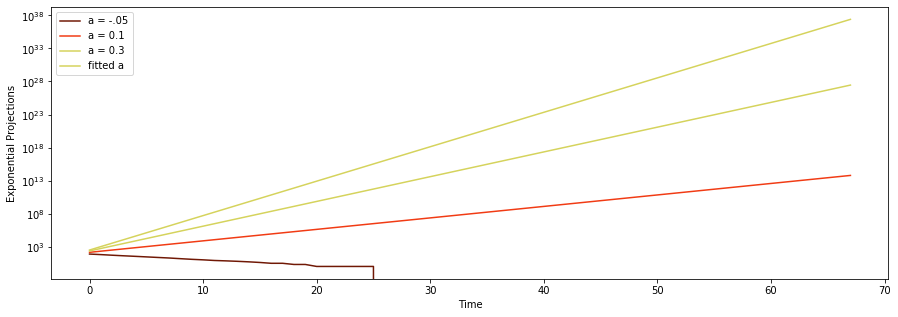

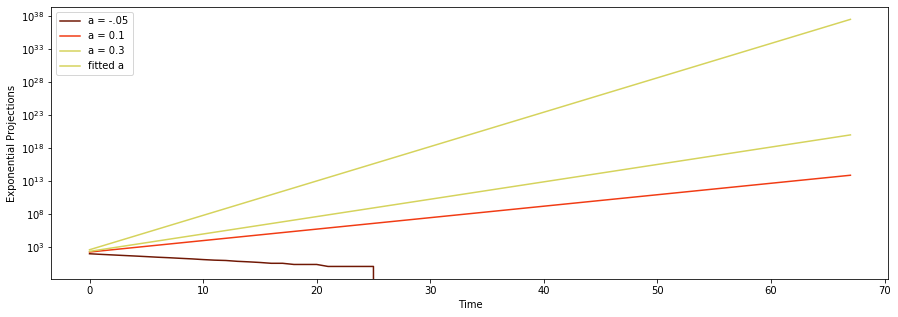

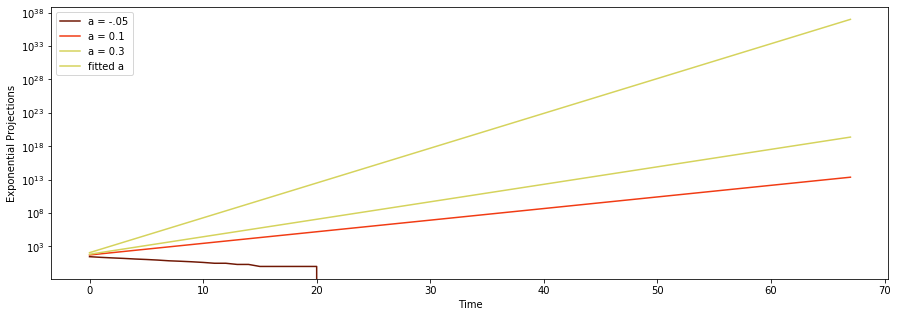

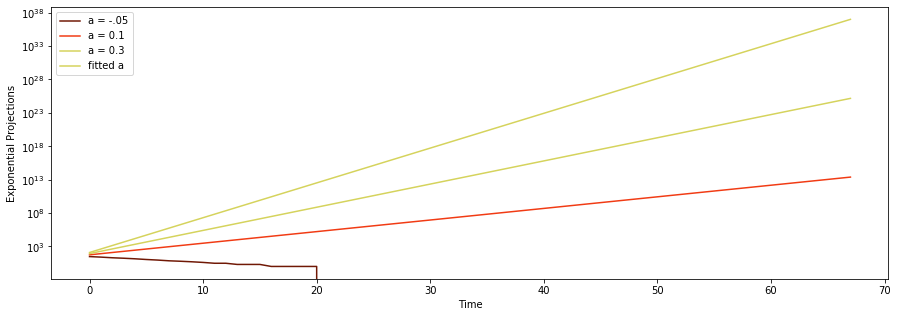

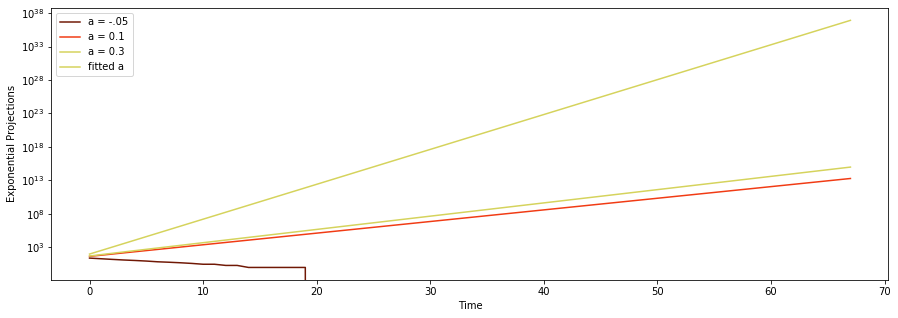

In [49]:
dim = 68
    
for state in state_list:
    state_df = statewise_merged_df[statewise_merged_df.state==state]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), state_df['infected_count_fixExp_a_-0.05'], color = '#701805', label = "a = -.05")
    ax.plot(range(dim), state_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "a = 0.1")
    ax.plot(range(dim), state_df['infected_count_fixExp_a_0.3'], color = '#D5D35C', label = "a = 0.3")
    ax.plot(range(dim), state_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted a")
#    ax.fill_between(range(dim), state_df['infected_count_fitExp'], state_df['infected_count_fixExp_a_0.3'], alpha=0.2, color = '#D5725C')
    #plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
    plt.xlabel("Time")
    plt.ylabel("Exponential Projections")
    ax.set_yscale('log')
    ax.legend()
    # ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + state + "exp_model_log_scale.png"
    plt.savefig(outfile)

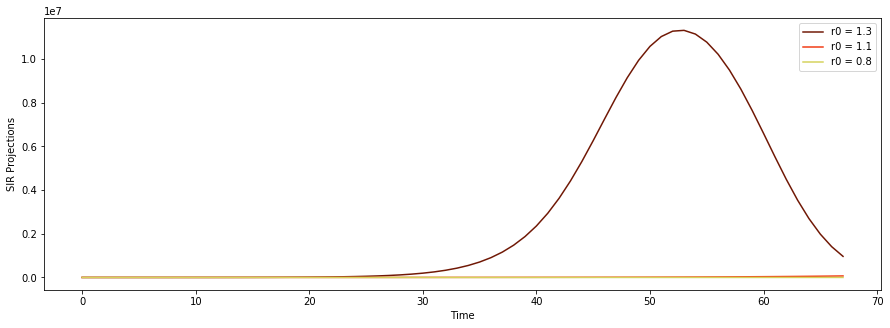

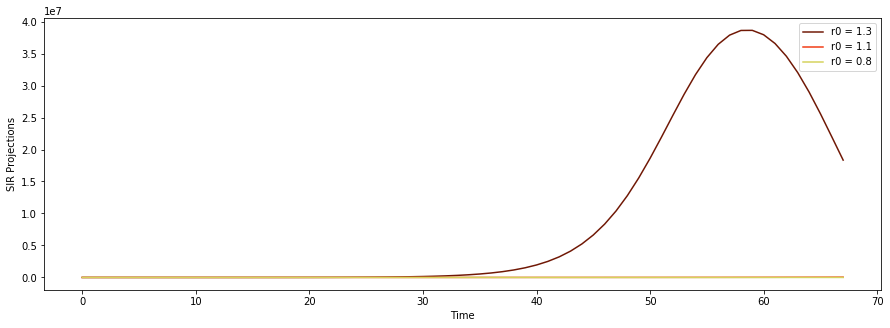

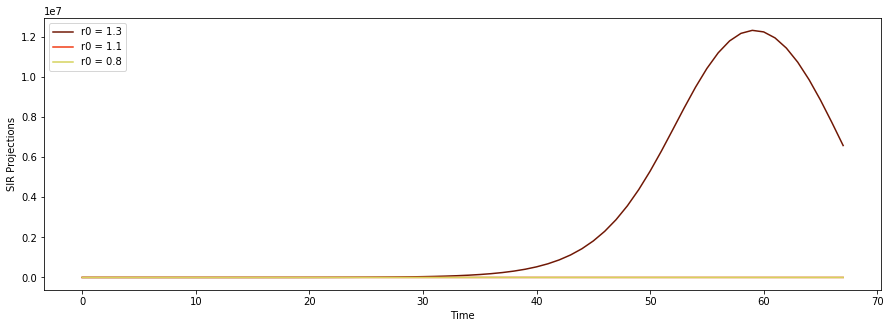

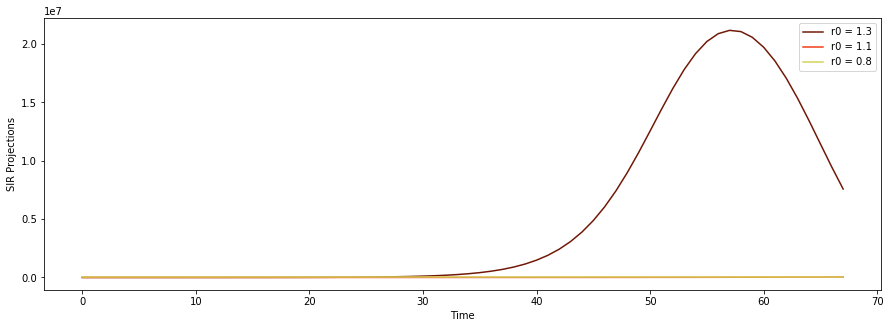

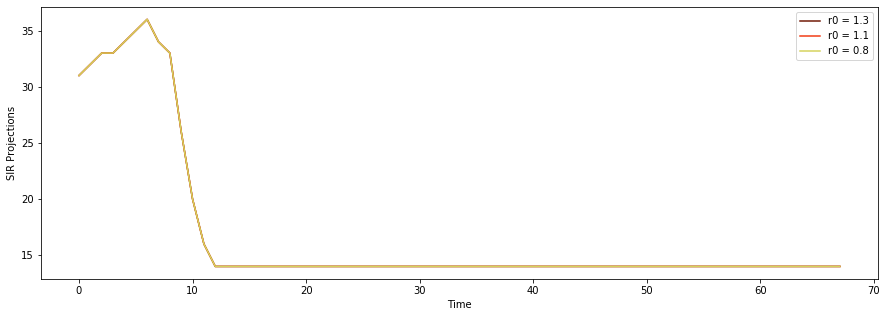

In [50]:
dim = 68
    
for state in state_list:
    state_df = statewise_merged_df[statewise_merged_df.state==state]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), state_df['infected_count_sir_r0_1.3'], color = '#701805', label = "r0 = 1.3")
    ax.plot(range(dim), state_df['infected_count_sir_r0_1.1'], color = '#F13B14', label = "r0 = 1.1")
    ax.plot(range(dim), state_df['infected_count_sir_r0_0.8'], color = '#D5D35C', label = "r0 = 0.8")
#    ax.fill_between(range(dim), state_df['infected_count_sir_r0_1.3'], state_df['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
    #plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
    plt.xlabel("Time")
    plt.ylabel("SIR Projections")
    ax.legend()
    # ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + state + "SIR_model.png"
    plt.savefig(outfile)

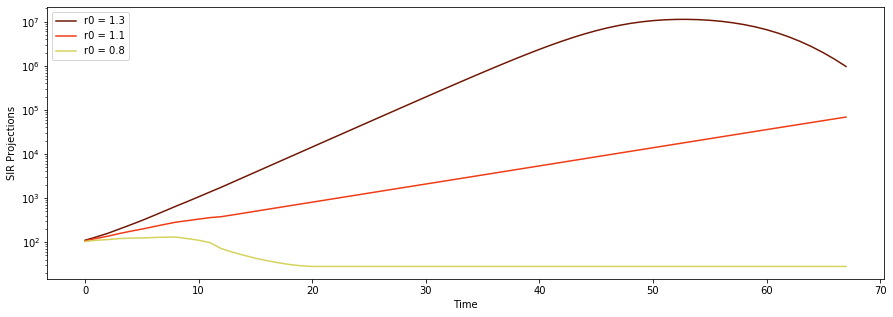

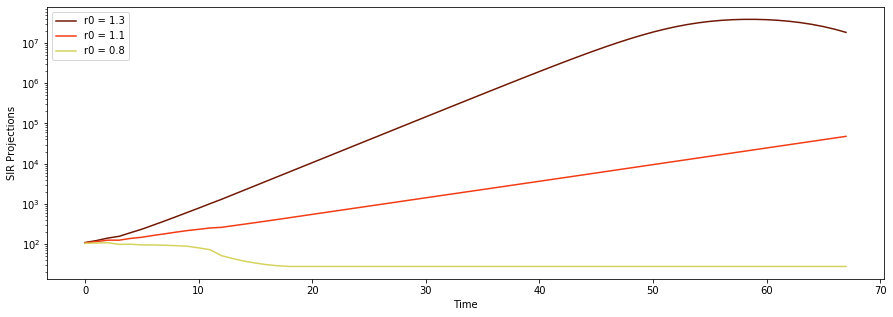

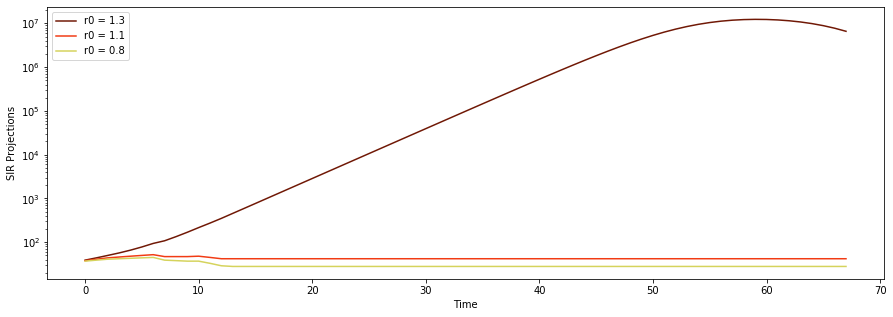

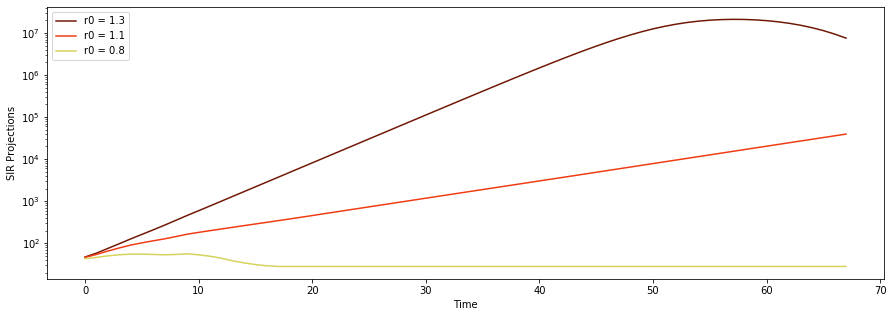

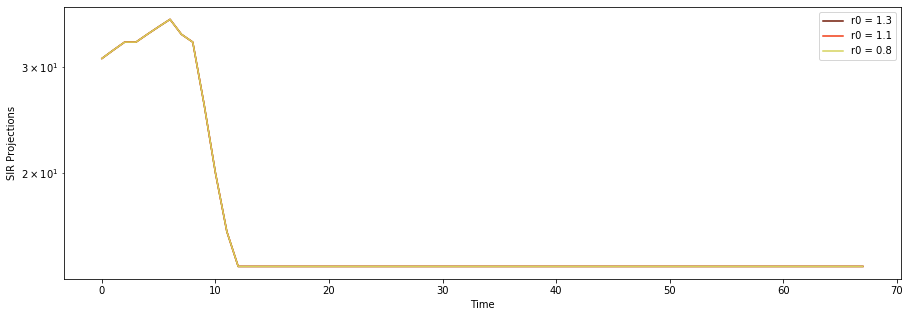

In [51]:
dim = 68
    
for state in state_list:
    state_df = statewise_merged_df[statewise_merged_df.state==state]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), state_df['infected_count_sir_r0_1.3'], color = '#701805', label = "r0 = 1.3")
    ax.plot(range(dim), state_df['infected_count_sir_r0_1.1'], color = '#F13B14', label = "r0 = 1.1")
    ax.plot(range(dim), state_df['infected_count_sir_r0_0.8'], color = '#D5D35C', label = "r0 = 0.8")
#    ax.fill_between(range(dim), state_df['infected_count_sir_r0_1.3'], state_df['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
    #plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
    plt.xlabel("Time")
    plt.ylabel("SIR Projections")
    ax.set_yscale('log')
    ax.legend()
    # ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + state + "SIR_model_log_scale.png"
    plt.savefig(outfile)

### District

In [52]:
district_list = ['Kasaragod','Hyderabad','Bengaluru','Kannur','Sangli','Pune','Chennai','Ernakulam']

ValueError: x and y must have same first dimension, but have shapes (68,) and (0,)

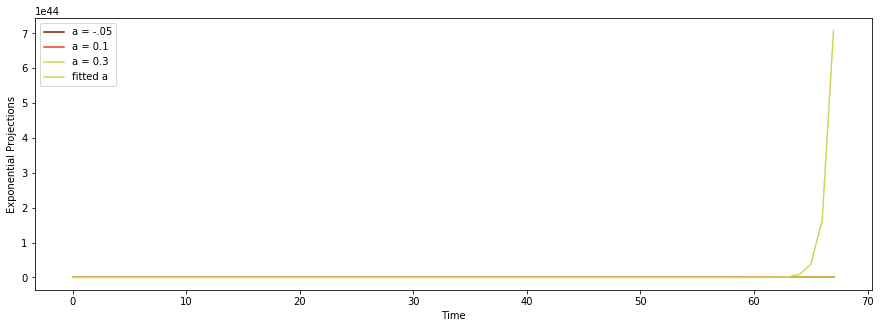

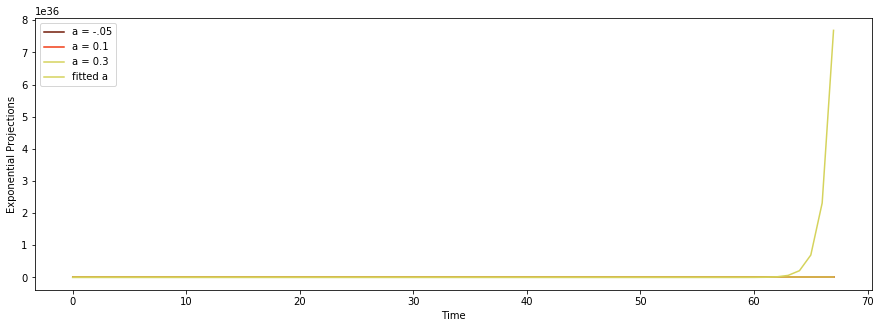

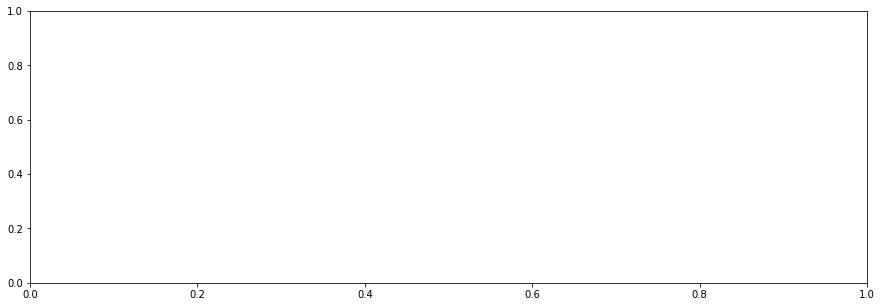

In [53]:
dim = 68
    
for district in district_list:
    district_df = districtwise_merged_df[districtwise_merged_df.district==district]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), district_df['infected_count_fixExp_a_-0.05'], color = '#701805', label = "a = -.05")
    ax.plot(range(dim), district_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "a = 0.1")
    ax.plot(range(dim), district_df['infected_count_fixExp_a_0.3'], color = '#D5D35C', label = "a = 0.3")
    ax.plot(range(dim), district_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted a")
#    ax.fill_between(range(dim), district_df['infected_count_fitExp'], district_df['infected_count_fixExp_a_0.3'], alpha=0.2, color = '#D5725C')
    #plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
    plt.xlabel("Time")
    plt.ylabel("Exponential Projections")
    #ax.set_yscale('log')
    ax.legend()
    # ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + district + "exp_model.png"
    plt.savefig(outfile)

ValueError: x and y must have same first dimension, but have shapes (68,) and (0,)

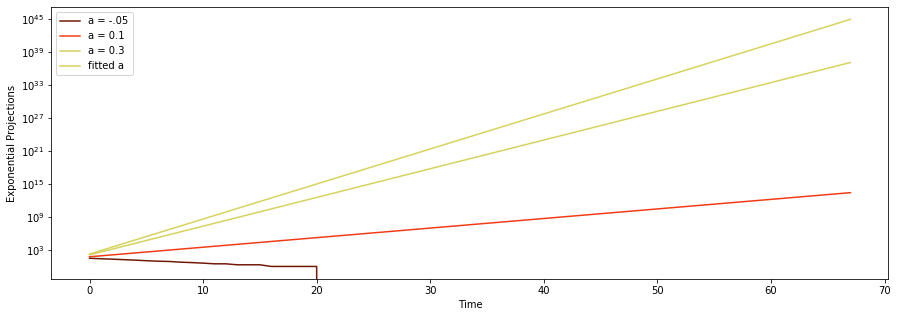

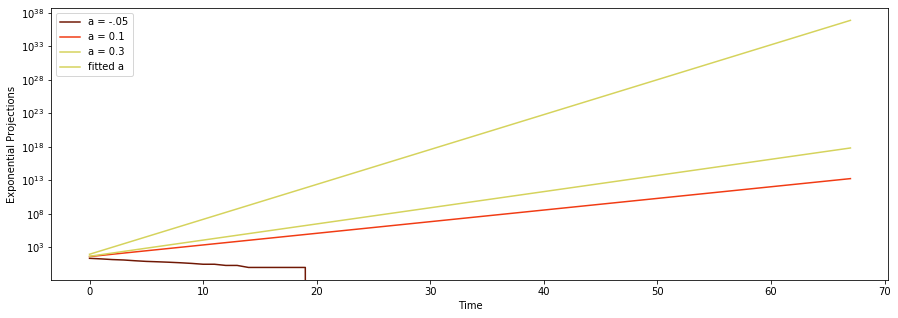

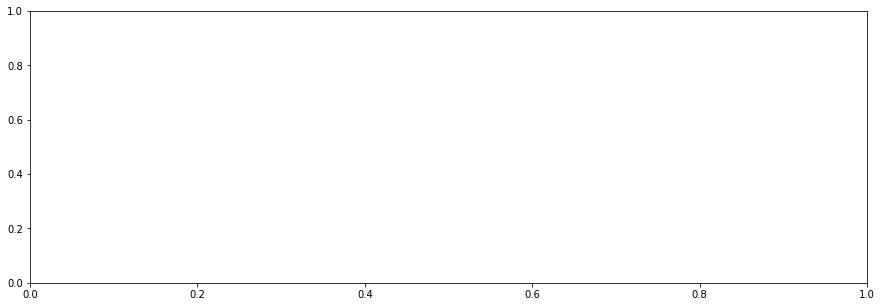

In [54]:
dim = 68
    
for district in district_list:
    district_df = districtwise_merged_df[districtwise_merged_df.district==district]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), district_df['infected_count_fixExp_a_-0.05'], color = '#701805', label = "a = -.05")
    ax.plot(range(dim), district_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "a = 0.1")
    ax.plot(range(dim), district_df['infected_count_fixExp_a_0.3'], color = '#D5D35C', label = "a = 0.3")
    ax.plot(range(dim), district_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted a")
#    ax.fill_between(range(dim), district_df['infected_count_fitExp'], district_df['infected_count_fixExp_a_0.3'], alpha=0.2, color = '#D5725C')
    #plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
    plt.xlabel("Time")
    plt.ylabel("Exponential Projections")
    ax.set_yscale('log')
    ax.legend()
    # ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + district + "exp_model_log_scale.png"
    plt.savefig(outfile)

ValueError: x and y must have same first dimension, but have shapes (68,) and (0,)

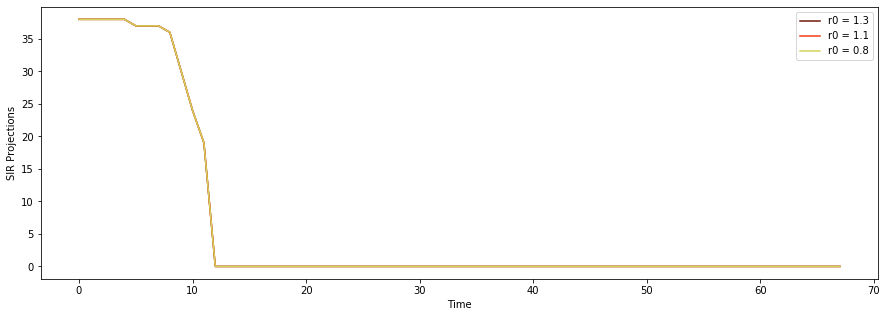

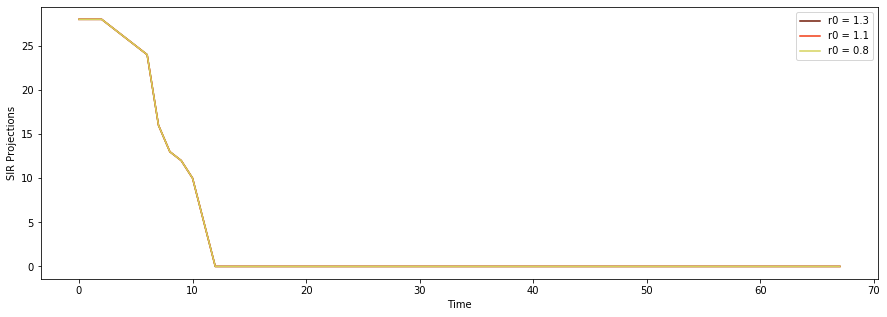

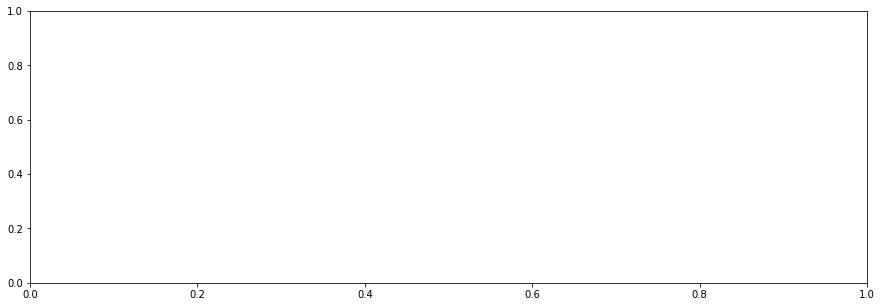

In [55]:
dim = 68
    
for district in district_list:
    district_df = districtwise_merged_df[districtwise_merged_df.district==district]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), district_df['infected_count_sir_r0_1.3'], color = '#701805', label = "r0 = 1.3")
    ax.plot(range(dim), district_df['infected_count_sir_r0_1.1'], color = '#F13B14', label = "r0 = 1.1")
    ax.plot(range(dim), district_df['infected_count_sir_r0_0.8'], color = '#D5D35C', label = "r0 = 0.8")
#    ax.fill_between(range(dim), district_df['infected_count_sir_r0_1.3'], district_df['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
    #plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
    plt.xlabel("Time")
    plt.ylabel("SIR Projections")
    ax.legend()
    # ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + district + "SIR_model.png"
    plt.savefig(outfile)

ValueError: x and y must have same first dimension, but have shapes (68,) and (0,)

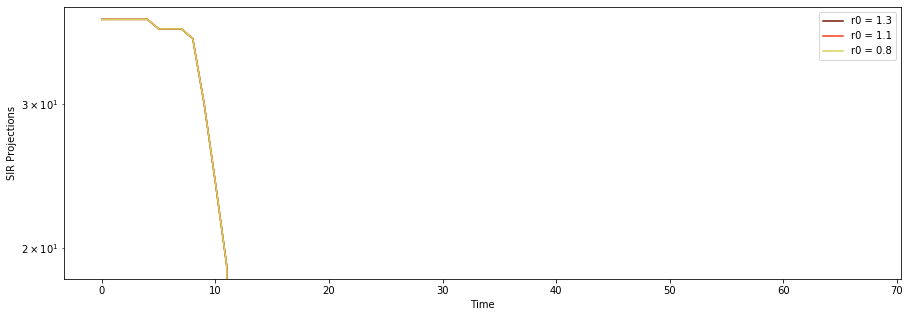

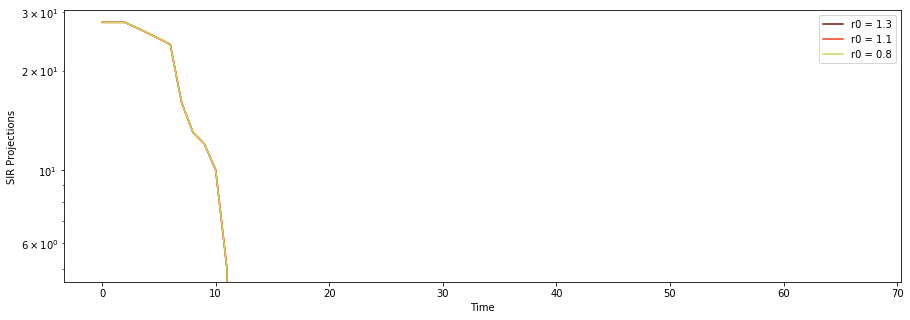

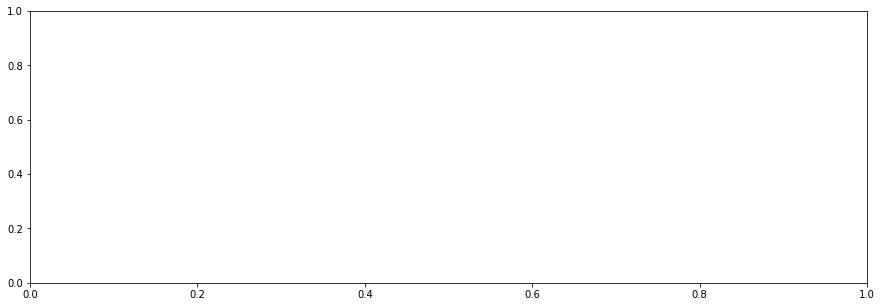

In [56]:
dim = 68
    
for district in district_list:
    district_df = districtwise_merged_df[districtwise_merged_df.district==district]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), district_df['infected_count_sir_r0_1.3'], color = '#701805', label = "r0 = 1.3")
    ax.plot(range(dim), district_df['infected_count_sir_r0_1.1'], color = '#F13B14', label = "r0 = 1.1")
    ax.plot(range(dim), district_df['infected_count_sir_r0_0.8'], color = '#D5D35C', label = "r0 = 0.8")
#    ax.fill_between(range(dim), district_df['infected_count_sir_r0_1.3'], district_df['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
    #plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
    plt.xlabel("Time")
    plt.ylabel("SIR Projections")
    ax.set_yscale('log')
    ax.legend()
    # ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + district + "SIR_model_log_scale.png"
    plt.savefig(outfile)

### Plots - 3 best models

### Country

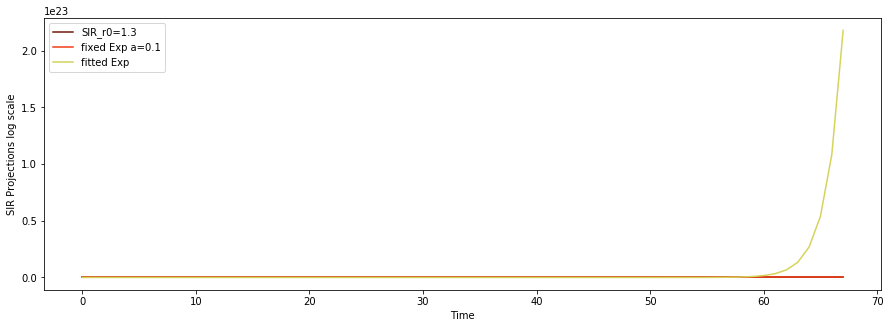

In [57]:
# plt.figure(figsize=(10,40))

dim = 68

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(dim), country_merged_df['infected_count_sir_r0_1.3'], color = '#701805', label = "SIR_r0=1.3")
ax.plot(range(dim), country_merged_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "fixed Exp a=0.1")
ax.plot(range(dim), country_merged_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted Exp")
ax.fill_between(range(dim), country_merged_df['infected_count_sir_r0_1.3'], country_merged_df['infected_count_fixExp_a_0.1'], alpha=0.2, color = '#D5725C')
plt.xlabel("Time")
plt.ylabel("SIR Projections log scale")
#ax.set_yscale('log')
ax.legend()
#ax.plot(x, y, 'o', color='tab:brown')
plt.savefig("plots/country_3best_models.png")

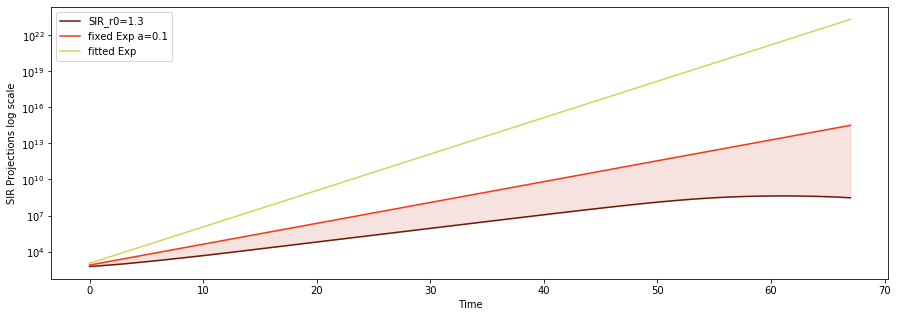

In [58]:
# plt.figure(figsize=(10,40))

dim = 68

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(dim), country_merged_df['infected_count_sir_r0_1.3'], color = '#701805', label = "SIR_r0=1.3")
ax.plot(range(dim), country_merged_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "fixed Exp a=0.1")
ax.plot(range(dim), country_merged_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted Exp")
ax.fill_between(range(dim), country_merged_df['infected_count_sir_r0_1.3'], country_merged_df['infected_count_fixExp_a_0.1'], alpha=0.2, color = '#D5725C')
plt.xlabel("Time")
plt.ylabel("SIR Projections log scale")
ax.set_yscale('log')
ax.legend()
#ax.plot(x, y, 'o', color='tab:brown')
plt.savefig("plots/country_3best_models_logscale.png")

### State

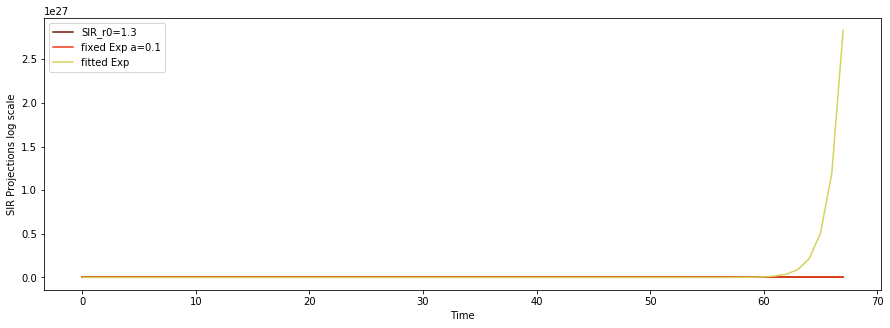

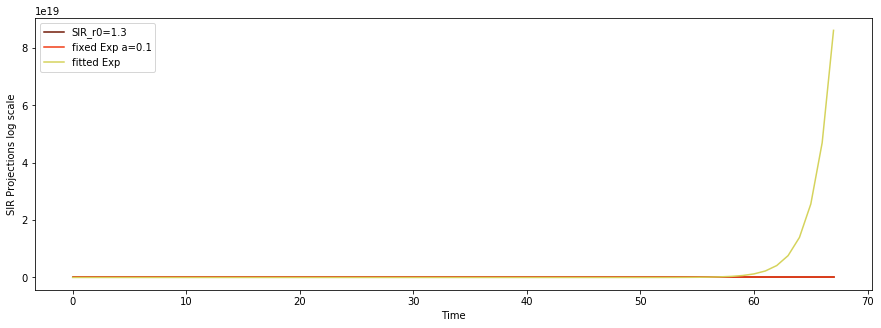

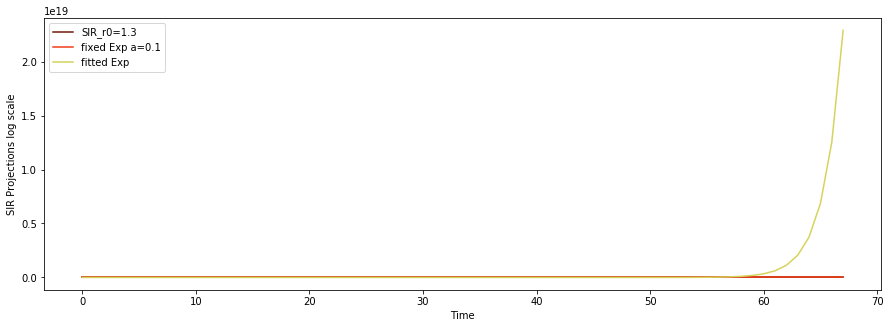

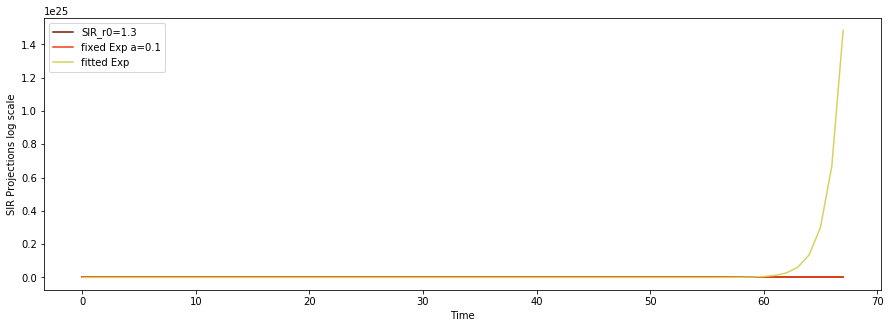

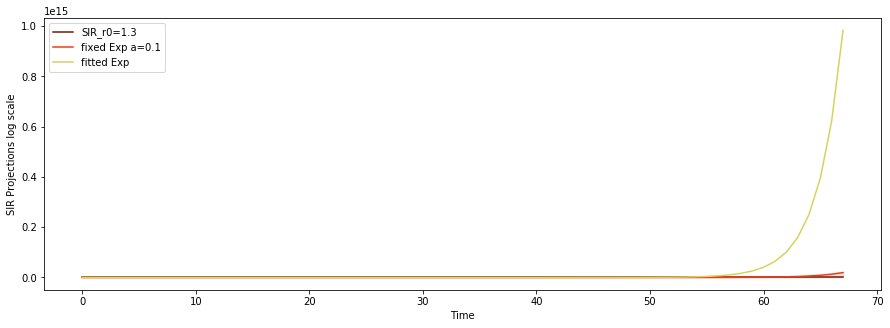

In [59]:
for state in state_list:
    state_df = statewise_merged_df[statewise_merged_df.state==state]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), state_df['infected_count_sir_r0_1.3'], color = '#701805', label = "SIR_r0=1.3")
    ax.plot(range(dim), state_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "fixed Exp a=0.1")
    ax.plot(range(dim), state_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted Exp")
    ax.fill_between(range(dim), state_df['infected_count_sir_r0_1.3'], state_df['infected_count_fixExp_a_0.1'], alpha=0.2, color = '#D5725C')
    plt.xlabel("Time")
    plt.ylabel("SIR Projections log scale")
    #ax.set_yscale('log')
    ax.legend()
    #ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + state + "3best_models.png"
    plt.savefig(outfile)

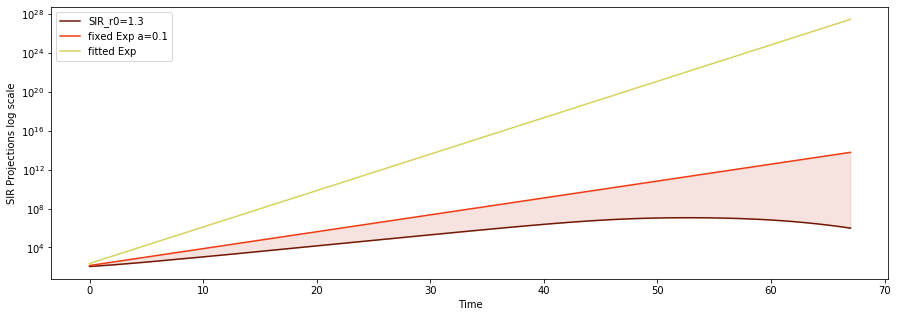

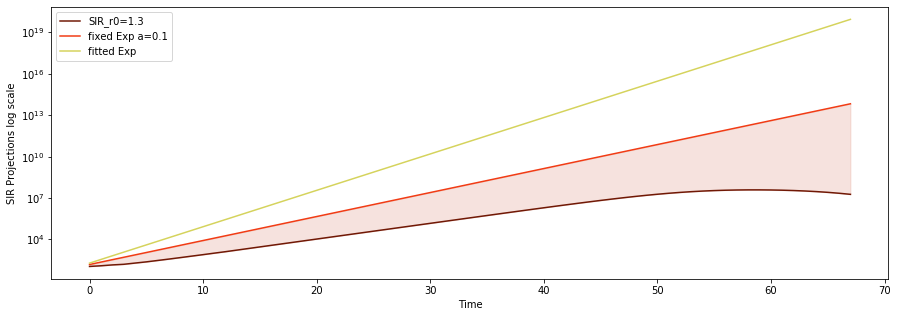

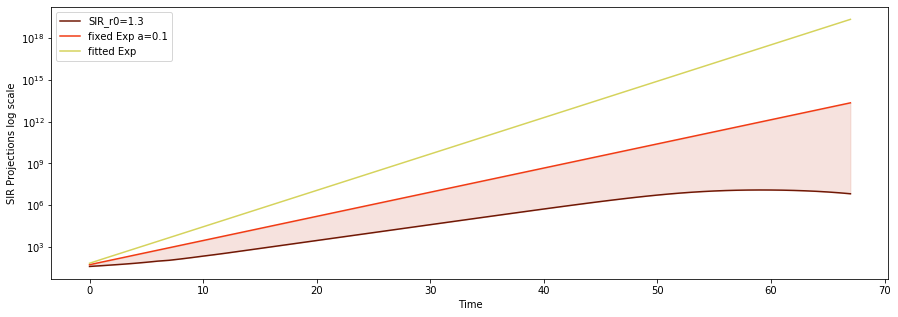

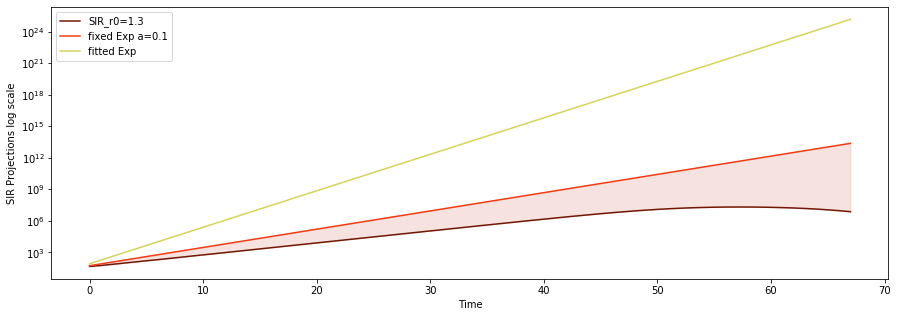

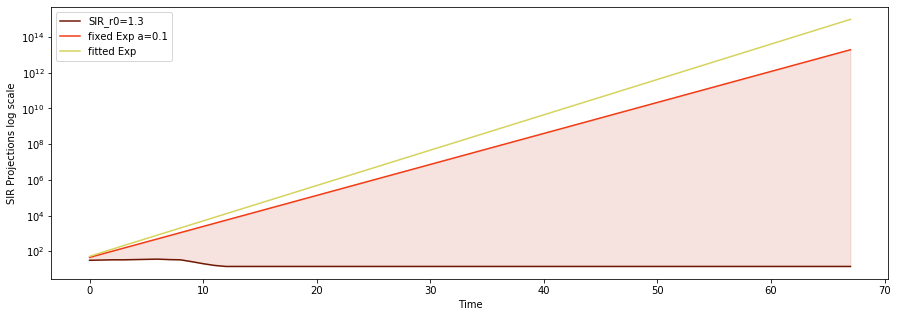

In [60]:
for state in state_list:
    state_df = statewise_merged_df[statewise_merged_df.state==state]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), state_df['infected_count_sir_r0_1.3'], color = '#701805', label = "SIR_r0=1.3")
    ax.plot(range(dim), state_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "fixed Exp a=0.1")
    ax.plot(range(dim), state_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted Exp")
    ax.fill_between(range(dim), state_df['infected_count_sir_r0_1.3'], state_df['infected_count_fixExp_a_0.1'], alpha=0.2, color = '#D5725C')
    plt.xlabel("Time")
    plt.ylabel("SIR Projections log scale")
    ax.set_yscale('log')
    ax.legend()
    #ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + state + "3best_models_logscale.png"
    plt.savefig(outfile)

### District

ValueError: x and y must have same first dimension, but have shapes (68,) and (0,)

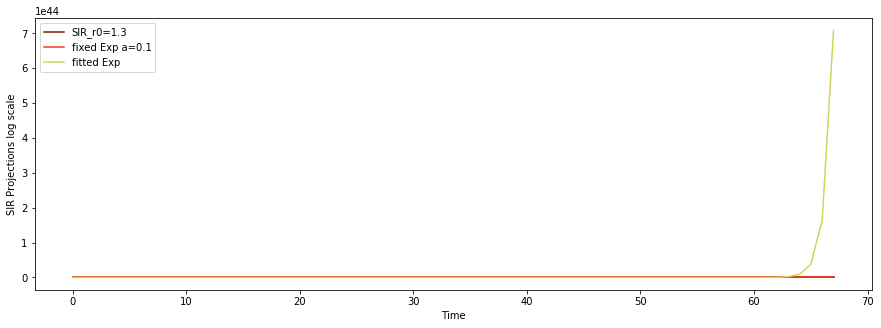

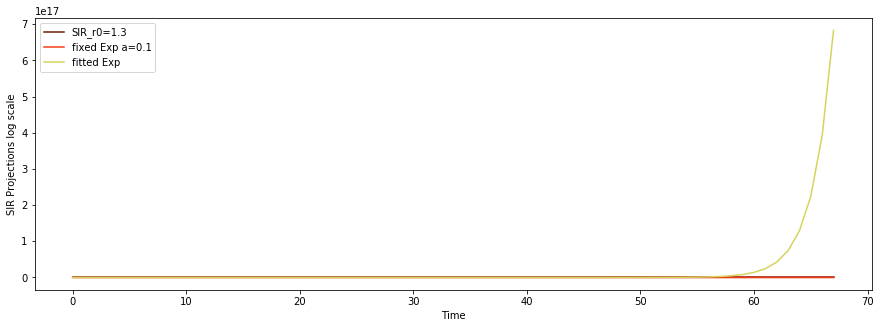

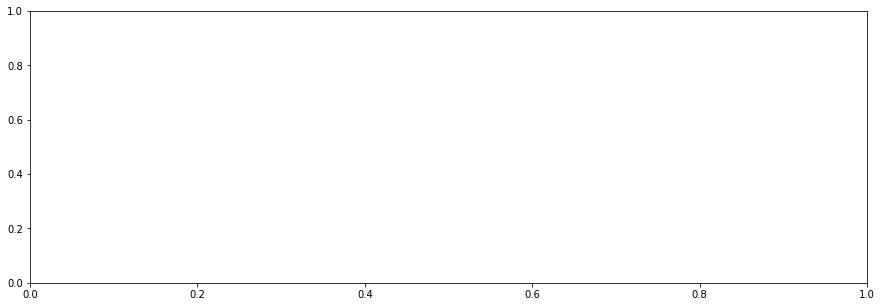

In [61]:
for district in district_list:
    district_df = districtwise_merged_df[districtwise_merged_df.district==district]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), district_df['infected_count_sir_r0_1.3'], color = '#701805', label = "SIR_r0=1.3")
    ax.plot(range(dim), district_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "fixed Exp a=0.1")
    ax.plot(range(dim), district_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted Exp")
    ax.fill_between(range(dim), district_df['infected_count_sir_r0_1.3'], district_df['infected_count_fixExp_a_0.1'], alpha=0.2, color = '#D5725C')
    plt.xlabel("Time")
    plt.ylabel("SIR Projections log scale")
    #ax.set_yscale('log')
    ax.legend()
    #ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + district + "3best_models.png"
    plt.savefig(outfile)

ValueError: x and y must have same first dimension, but have shapes (68,) and (0,)

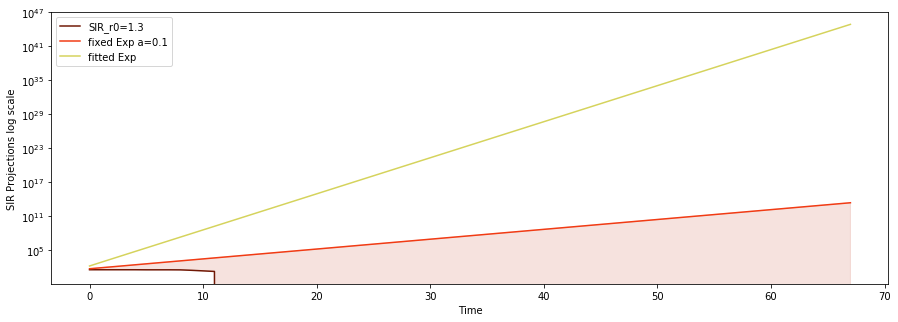

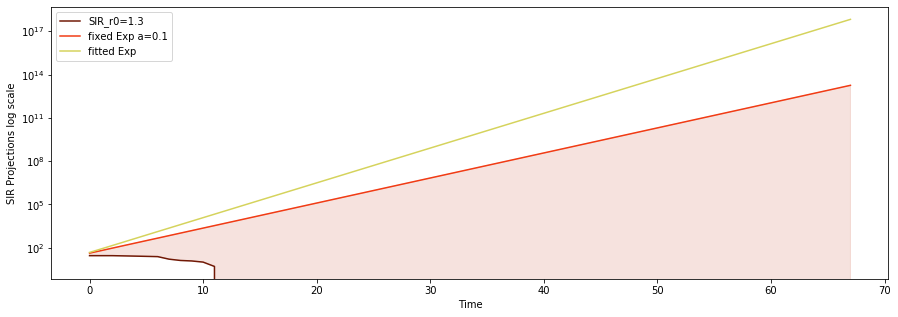

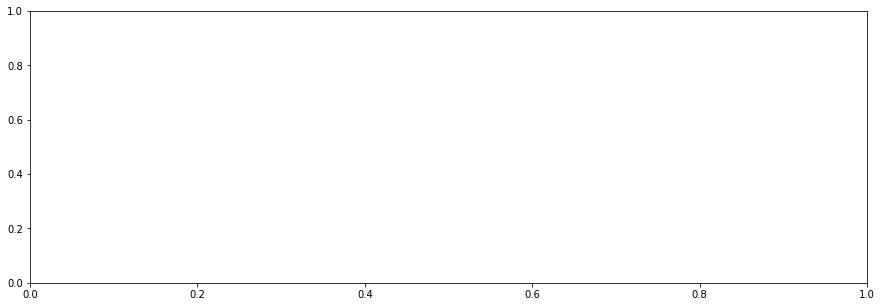

In [62]:
for district in district_list:
    district_df = districtwise_merged_df[districtwise_merged_df.district==district]
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(dim), district_df['infected_count_sir_r0_1.3'], color = '#701805', label = "SIR_r0=1.3")
    ax.plot(range(dim), district_df['infected_count_fixExp_a_0.1'], color = '#F13B14', label = "fixed Exp a=0.1")
    ax.plot(range(dim), district_df['infected_count_fitExp'], color = '#D5D35C', label = "fitted Exp")
    ax.fill_between(range(dim), district_df['infected_count_sir_r0_1.3'], district_df['infected_count_fixExp_a_0.1'], alpha=0.2, color = '#D5725C')
    plt.xlabel("Time")
    plt.ylabel("SIR Projections log scale")
    ax.set_yscale('log')
    ax.legend()
    #ax.plot(x, y, 'o', color='tab:brown')
    outfile = "plots/" + district + "3best_models_logscale.png"
    plt.savefig(outfile)

In [22]:
keralaDf = mergedDf[mergedDf['state'] == 'Kerala']

In [23]:
keralaDf.columns

Index(['state', 'projection_date', 'infected_count_sir_r0_1.3',
       'infected_count_sir_r0_1.1', 'infected_count_sir_r0_0.8',
       'infected_count_fitExp', 'a_fitted'],
      dtype='object')

In [24]:
import matplotlib.pyplot as plt

In [36]:
print(keralaDf['infected_count_fitExp'])

0             116
1             145
2             183
3             222
4             277
5             344
6             427
7             528
8             656
9             814
10           1010
11           1253
12           1555
13           1929
14           2393
15           2969
16           3684
17           4571
18           5671
19           7036
20           8730
21          10831
22          13438
23          16673
24          20686
25          25665
26          31843
27          39508
28          49018
29          60817
         ...     
57       25513583
58       31654902
59       39274484
60       48728159
61       60457408
62       75009979
63       93065467
64      115467052
65      143260874
66      177744886
67      220529469
68      273612636
69      339473336
70      421187221
71      522570277
72      648357027
73      804421631
74      998052205
75     1238291171
76     1536357534
77     1906170800
78     2365001010
79     2934275237
80     3640578220
81     451

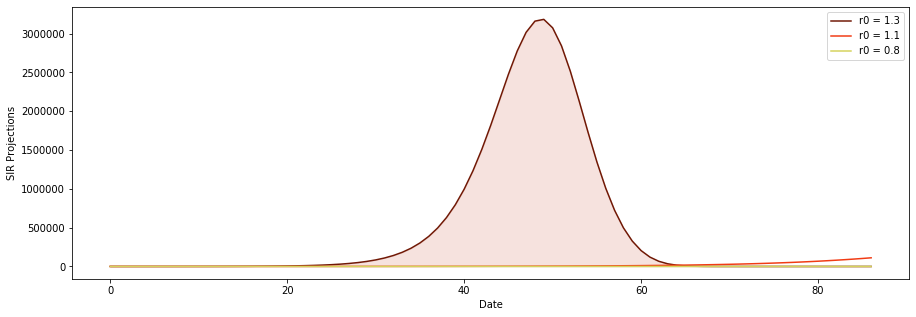

In [37]:
# plt.figure(figsize=(10,40))

dim = 87

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(range(dim), keralaDf['infected_count_sir_r0_1.3'], color = '#701805', label = "r0 = 1.3")
ax.plot(range(dim), keralaDf['infected_count_sir_r0_1.1'], color = '#F13B14', label = "r0 = 1.1")
ax.plot(range(dim), keralaDf['infected_count_sir_r0_0.8'], color = '#D5D35C', label = "r0 = 0.8")
ax.fill_between(range(dim), keralaDf['infected_count_sir_r0_1.3'], keralaDf['infected_count_sir_r0_0.8'], alpha=0.2, color = '#D5725C')
#plt.xticks(range(-1,dim, 7), keralaDf['projection_date'].dt.date[range(0, dim, 7)], rotation = 60)
plt.xlabel("Date")
plt.ylabel("SIR Projections")
#ax.set_yscale('log')
ax.legend()
# ax.plot(x, y, 'o', color='tab:brown')

In [80]:
plt.savefig("sir_incubation.png")